# Chapter 6: Compare NOAA/NSIDC SIC with Surface Air Temperature

## Learning Objectives
Investigate how surface air temperature affects sea ice concentration.

This notebook uses surface air temperature anomalies from the NOAA [National Centers for Environmental Prediction (NCEP)](https://www.emc.ncep.noaa.gov/emc.php) Reanalysis products. The data was downloaded from the NOAA [Physcial Sciences Laboratory Monthly/Seasonal Climate Composites](https://psl.noaa.gov/cgi-bin/data/composites/printpage.pl) web application.

### Import relevant packages

In [1]:
from datetime import datetime, date, timedelta
from netCDF4 import Dataset

import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas
import packaging
import aiohttp

import fsspec
import pystac
import netCDF4
from netCDF4 import Dataset
import h5netcdf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Open the NCEP air temperature anomaly NetCDF file

**Note:** This data file was downloaded from the NOAA [Physcial Sciences Laboratory Monthly/Seasonal Climate Composites](https://psl.noaa.gov/cgi-bin/data/composites/printpage.pl) web application and was reprojected to match the CDR grid and resolution. It is included with these notebooks for easy access and use in this learning notebook.

In [2]:
# Read in the NCEP air temparture anomaly file with xarray
ncep_air_temp_fn = 'data_files/ncep-air-temp-3411crs-oct2020.nc'
ncep_air_temp_nc = xr.open_dataset(ncep_air_temp_fn)
ncep_air_temp_nc

<xarray.Dataset> Size: 551kB
Dimensions:              (x: 304, y: 448)
Coordinates:
  * x                    (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                    (y) float64 4kB -5.338e+06 -5.312e+06 ... 5.838e+06
Data variables:
    polar_stereographic  |S1 1B ...
    Band1                (y, x) float32 545kB ...
Attributes:
    Conventions:                  COARDS
    description:                  Computed from the web page https://psl.noaa...
    GDAL:                         GDAL 3.9.1, released 2024/06/22
    GDAL_NETCDF_DIM_EXTRA:        {time}
    GDAL_NETCDF_DIM_time_DEF:     [1 6]
    GDAL_NETCDF_DIM_time_VALUES:  1935792
    history:                      Fri Aug 30 14:26:39 2024: GDAL CreateCopy( ...
    title:                        Composite Anomaly

### Extract the air temperature data

In [3]:
# From the listing above, we see that the data variable is called "Band1". Extract that into a numpy array
ncep_air_temp_var = ncep_air_temp_nc.variables['Band1']
ncep_air_temp = np.array(ncep_air_temp_var.data)

# This data set happens to be rotated compared to our sea ice data so need to flip it so we can graph them together
ncep_air_temp_flip = np.flipud(ncep_air_temp)

### Plot the air temperature data
Note that the white line is an artifact of the reprojection of the data and is a swath of missing data along the prime meridian.

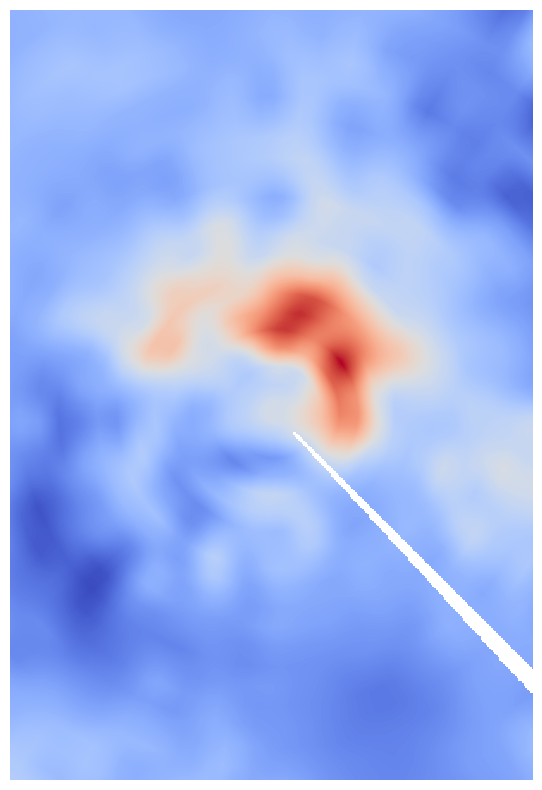

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 10))
air_temp_plot = ax1.imshow(ncep_air_temp_flip, cmap='coolwarm', interpolation='bilinear')
plt.axis('off')
plt.show()

### Open CDR data

This will be smiliar code as was used in Notebooks 2 and 3 but for the Northern Hemisphere monthly data.

In [5]:
# Read in the STAC collection
collection = pystac.Collection.from_file('https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json')
# Extract all the items and their ids from the collection into a variable
items = list(collection.get_all_items())
item_ids = [i.id for i in items]
# Find the id for the monthly NH file to get its URL
monthly_nh = [i for i in item_ids if "monthly_nh" in i]
monthly_nh_item = collection.get_item(monthly_nh[0], recursive=True)
#netcdf_url = monthly_nh_item.assets['netcdf'].href # !!!!!!! Won't work until the STAC is updated after a data update !!!!!!
netcdf_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/aggregate/seaice_conc_monthly_nh_197811_202403_v04r00.nc'
# Open the data file
fs = fsspec.filesystem('https')
ds = xr.open_dataset(fs.open(netcdf_url))

<Item id=seaice_conc_monthly_nh_197811_202312_v04r00>


In [7]:
# Pull out sea ice concentration variable into numpy array. Note that the variable name for the monthly data is cdr_seaice_conc_monthly
cdr_seaice_conc_var = ds.variables['cdr_seaice_conc_monthly']
cdr_seaice_conc = np.array(cdr_seaice_conc_var.data)

# We want to extract Oct 2020 data. Find index where that occurs.
time_var = ds.variables['time']
time = np.array(time_var.data)
oct_index = np.where(time == np.datetime64(datetime(2020, 10, 1)))

# Here we are pulling out the Oct 2020 data from our cdr_seaice_conc variable.
seaice_conc_oct2020 = np.squeeze(cdr_seaice_conc[oct_index[0],:,:])

# Set all concentrations less than 15 to ocean (0)
is_not_seaice = seaice_conc_oct2020 < .15
seaice_conc_oct2020[is_not_seaice] = 0

array([[0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       ...,
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ]], dtype=float32)

### Plot sea ice

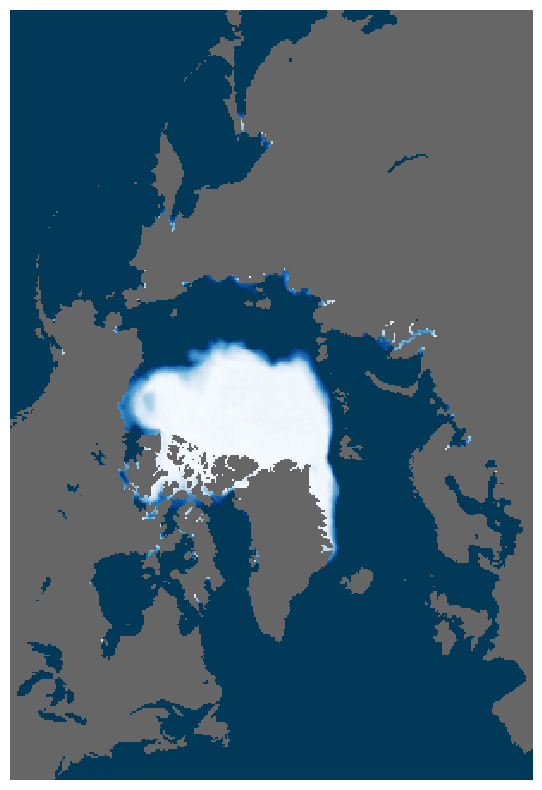

In [10]:
#filter out the ocean where pixels = 0
ocean = ma.masked_outside(seaice_conc_oct2020, 0, 0)

# Only keep sea ice conentration >= 15%
sic_15 = ma.masked_outside(seaice_conc_oct2020, .15, 1)

# filter out the land, coast, and lakes
land = ma.masked_outside(seaice_conc_oct2020, 2.54, 2.54)
coast = ma.masked_outside(seaice_conc_oct2020, 2.53, 2.53)
lakes = ma.masked_outside(seaice_conc_oct2020, 2.52, 2.52)

fig, ax1 = plt.subplots(figsize=(8, 10))
seaice_15_plot = ax1.imshow(sic_15, cmap='Blues_r', interpolation='none')
land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none')
coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none')
ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none')
lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none')
plt.axis('off')
plt.show()

### Plot the two together

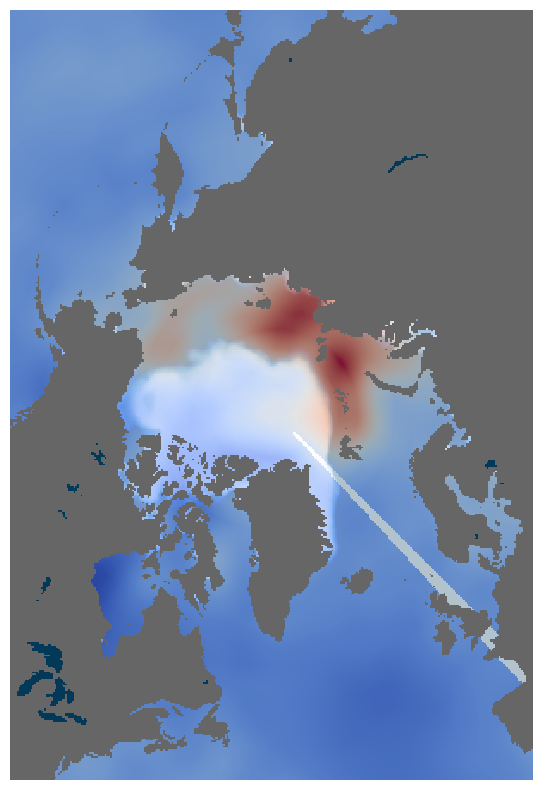

In [12]:
fig, ax1 = plt.subplots(figsize=(8, 10))
ncep = ax1.imshow(ncep_air_temp_flip, cmap='coolwarm')
seaice_15_plot = ax1.imshow(sic_15, cmap='Blues_r', interpolation='none', alpha=0.3)
land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none')
coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none')
ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none', alpha=0.3)
lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none')
plt.axis('off')
plt.show()